<a href="https://colab.research.google.com/github/elifsare/Real-time-Age-Gender-Ethnicity-Detection/blob/main/model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import os
!ls

Mounted at /content/drive
drive  sample_data


In [ ]:
from google.colab import files
files.upload()

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d nipunarora8/age-gender-and-ethnicity-face-data-csv

In [ ]:
!mkdir dataset

In [ ]:
!unzip '/content/age-gender-and-ethnicity-face-data-csv.zip' -d dataset

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Conv2D, BatchNormalization, MaxPooling2D, Flatten, Dense, Dropout,  AveragePooling2D, Activation, MaxPool2D
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from keras import regularizers

In [ ]:
df = pd.read_csv('/content/dataset/age_gender.csv')

In [ ]:
## Converting pixels into numpy array
num_pixels = len(df['pixels'][0].split(" "))
img_height = int(np.sqrt(len(df['pixels'][0].split(" "))))
img_width = int(np.sqrt(len(df['pixels'][0].split(" "))))
print(num_pixels, img_height, img_width)

2304 48 48


In [ ]:
df['pixels'] = df['pixels'].apply(lambda x: np.array(x.split(),dtype='float32'))

Data Visualization

In [ ]:
df1 = df.drop(['img_name', 'pixels'],axis=1)

In [ ]:
df1.nunique()

age          104
ethnicity      5
gender         2
dtype: int64

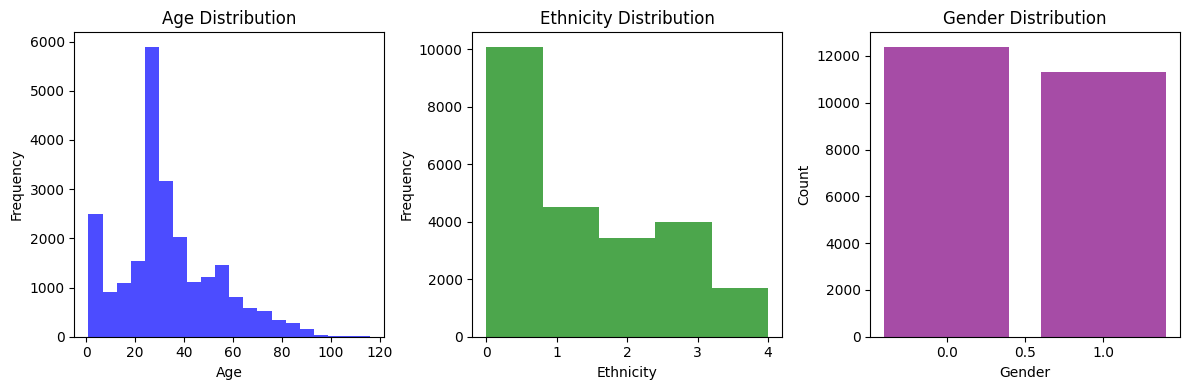

In [ ]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.hist(df['age'], bins=20, color='blue', alpha=0.7)
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Frequency')

plt.subplot(1, 3, 2)
plt.hist(df['ethnicity'], bins=5, color='green', alpha=0.7)
plt.title('Ethnicity Distribution')
plt.xlabel('Ethnicity')
plt.ylabel('Frequency')

plt.subplot(1, 3, 3)
plt.bar(df['gender'].value_counts().index, df['gender'].value_counts().values, color='purple', alpha=0.7)
plt.title('Gender Distribution')
plt.xlabel('Gender')
plt.ylabel('Count')

plt.tight_layout()
plt.show()

<ipython-input-13-0e4b9e94f6ca>:8: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(5, 5, i+1)


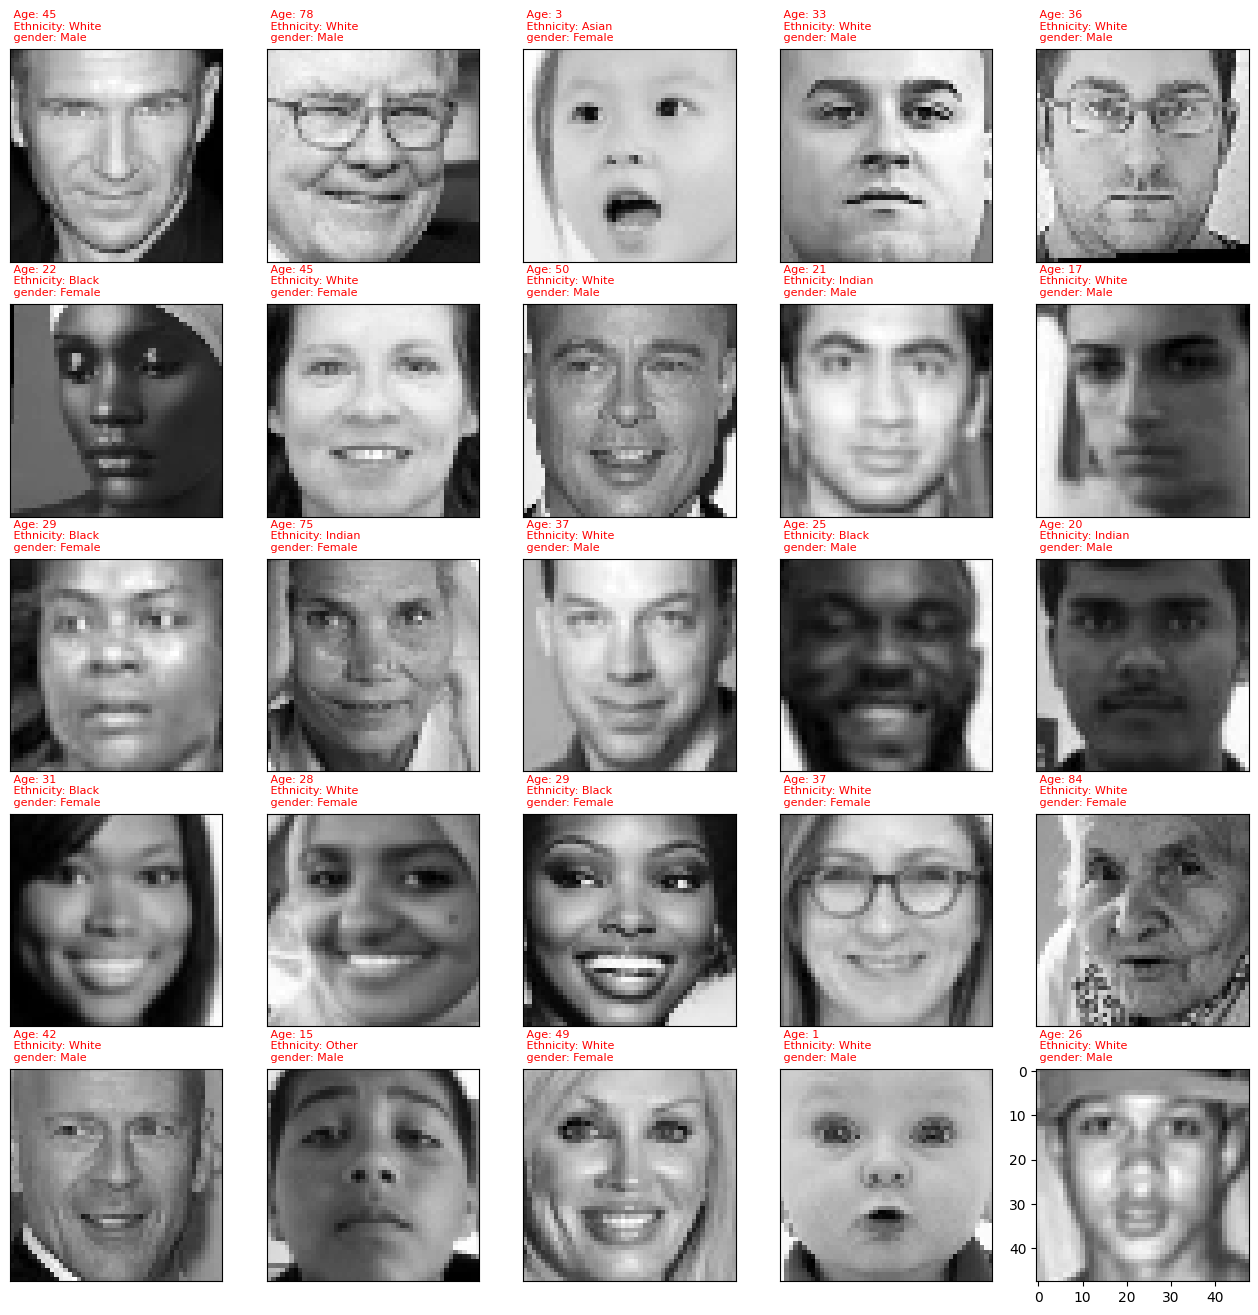

In [ ]:
plt.figure(figsize=(16, 16))

for i in range(25):
    index = np.random.randint(0, len(df))
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.subplot(5, 5, i+1)
    plt.imshow(df['pixels'].iloc[index].reshape(48, 48),"gray")
    plt.title(' Age: {}\n Ethnicity: {}\n gender: {}'.format(df['age'].iloc[index],
                                                             {0:"White", 1:"Black", 2:"Asian", 3:"Indian", 4:"Other"}[df['ethnicity'].iloc[index]],
                                                             {0:"Male", 1:"Female"}[df['gender'].iloc[index]]),
              loc="left",color='red',
              fontsize = 8)

plt.show()

In [ ]:
class GenderAgeEthnicityModel:
    def __init__(self, model_type, X, y, root, checkpoint_name):
        self.model_type = model_type
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(X, y, test_size=0.3, random_state=40)

        self.train_generator = ImageDataGenerator(width_shift_range=0.1,
                                                  height_shift_range=0.1,
                                                  horizontal_flip=True,
                                                  rescale=1./255,
                                                  validation_split=0.2)

        self.validation_generator = ImageDataGenerator(rescale=1./255,
                                                       validation_split=0.2)

        self.train_flow = self.train_generator.flow(self.X_test,
                                                    self.y_test,
                                                    batch_size=64)

        self.validation_flow = self.validation_generator.flow(self.X_test,
                                                              self.y_test,
                                                              batch_size=64)

        self.root = root

        self.checkpoint_name = checkpoint_name

        self.model = self.build_model()

    def build_model(self):
        model = Sequential()

        if self.model_type == 'age':
            # Age model architecture
            model.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu', input_shape=(48, 48,1)))

            model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
            model.add(BatchNormalization())
            model.add(MaxPooling2D((2, 2)))

            model.add(Conv2D(64, (3, 3), activation='relu'))
            model.add(MaxPooling2D((2, 2)))

            model.add(Conv2D(128, (3, 3), activation='relu'))
            model.add(MaxPooling2D((2, 2)))

            model.add(Flatten())

            model.add(Dense(64, activation='relu'))
            model.add(Dropout(rate=0.2))

            model.add(Dense(1, activation = 'relu'))

            model.compile(optimizer='adam',
                          loss='mean_squared_error',
                          metrics=['mae'])


        elif self.model_type == 'gender':
          # gender model architecture
            model.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu', input_shape=(48, 48,1)))
            model.add(Conv2D(64,(3,3), padding='same', activation='relu' ))
            model.add(BatchNormalization())
            model.add(MaxPool2D(pool_size=(2, 2)))

            model.add(Conv2D(128,(5,5), padding='same', activation='relu'))
            model.add(BatchNormalization())
            model.add(MaxPool2D(pool_size=(2, 2)))

            model.add(Conv2D(512,(3,3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.01)))
            model.add(BatchNormalization())
            model.add(MaxPool2D(pool_size=(2, 2)))

            model.add(Conv2D(512,(3,3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.01)))
            model.add(BatchNormalization())
            model.add(MaxPool2D(pool_size=(2, 2)))

            model.add(Flatten())
            model.add(Dense(256,activation = 'relu'))
            model.add(BatchNormalization())

            model.add(Dense(512,activation = 'relu'))
            model.add(BatchNormalization())
            model.add(Dropout(0.2))

            model.add(Dense(1, activation='sigmoid'))

            model.compile(optimizer='sgd',
                          loss='binary_crossentropy',
                          metrics=['accuracy'])


        elif self.model_type == 'ethnicity':
            # Ethnicity model architecture
            model.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu', input_shape=(48, 48,1)))
            model.add(Conv2D(64,(3,3), padding='same', activation='relu' ))
            model.add(BatchNormalization())
            model.add(MaxPool2D(pool_size=(2, 2)))

            model.add(Conv2D(128,(5,5), padding='same', activation='relu'))
            model.add(BatchNormalization())
            model.add(MaxPool2D(pool_size=(2, 2)))

            model.add(Conv2D(512,(3,3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.01)))
            model.add(BatchNormalization())
            model.add(MaxPool2D(pool_size=(2, 2)))

            model.add(Conv2D(512,(3,3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.01)))
            model.add(BatchNormalization())
            model.add(MaxPool2D(pool_size=(2, 2)))

            model.add(Flatten())
            model.add(Dense(256,activation = 'relu'))
            model.add(BatchNormalization())

            model.add(Dense(512,activation = 'relu'))
            model.add(BatchNormalization())
            model.add(Dropout(0.2))

            model.add(Dense(5, activation='sigmoid'))

            model.compile(optimizer='rmsprop',
                          loss='sparse_categorical_crossentropy',
                          metrics=['accuracy'])

        else:
            raise ValueError("Invalid model type. Supported types are 'age', 'gender', and 'ethnicity'.")

        return model


    def train_model(self, epochs, callbacks_list):
        h = self.model.fit(self.train_flow, epochs=epochs, batch_size=64, validation_split=0.1,
                           validation_data=self.validation_flow, callbacks=callbacks_list)
        return h

    def evaluate_model(self):
        train_loss, train_acc = self.model.evaluate(self.train_flow)
        test_loss, test_acc = self.model.evaluate(self.validation_flow)
        return train_loss, train_acc, test_loss, test_acc

    def plot_history(self, history):
      plt.figure(figsize=(14, 3))
      plt.subplot(1, 2, 1)
      plt.ylabel('Loss', fontsize=15)
      plt.plot(history.history['loss'], color='b', label='Training Loss')
      plt.plot(history.history['val_loss'], color='r', label='Validation Loss')

      plt.subplot(1, 2, 2)
      plt.ylabel('Metric', fontsize=15)

      if self.model_type == 'age':
        metric_label = 'Mean Absolute Error'
        metric_key = 'mae'
      elif self.model_type in ['gender', 'ethnicity']:
        metric_label = 'Accuracy'
        metric_key = 'accuracy'
      else:
        raise ValueError("Invalid model_type")

      plt.plot(history.history[metric_key], color='b', label=f'Training {metric_label}')
      plt.plot(history.history[f'val_{metric_key}'], color='r', label=f'Validation {metric_label}')

      plt.legend(loc='lower right')
      plt.show()


    def save_model_checkpoint(self):
        check_pointer = ModelCheckpoint(self.root + f'checkPoint_model_{self.model_type}.h5',
                                        verbose=1, save_best_only=True)
        return check_pointer

In [ ]:
X = np.array(df['pixels'].tolist())
X = np.reshape(X, (-1, 48, 48, 1))

# Age Model

In [ ]:
age_model = GenderAgeEthnicityModel('age', X, df['age'], '/content/drive/MyDrive/DeepLearningProject/Gender&Age/', 'age')

age_callbacks = [
    EarlyStopping(monitor='val_loss', min_delta=0, patience=6, verbose=1, restore_best_weights=True),
    age_model.save_model_checkpoint(),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, verbose=1, min_delta=0.0001)
]

In [ ]:
age_history = age_model.train_model(60, age_callbacks)

Epoch 1/60
111/112 [============================>.] - ETA: 0s - loss: 423.4985 - mae: 15.7895
Epoch 1: val_loss improved from inf to 1224.47229, saving model to /content/drive/MyDrive/DeepLearningProject/Gender&Age/checkPoint_model_age.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


112/112 [==============================] - 14s 48ms/step - loss: 422.4842 - mae: 15.7670 - val_loss: 1224.4723 - val_mae: 29.2670 - lr: 0.0010
Epoch 2/60
112/112 [==============================] - ETA: 0s - loss: 293.7555 - mae: 13.2900
Epoch 2: val_loss improved from 1224.47229 to 1216.47974, saving model to /content/drive/MyDrive/DeepLearningProject/Gender&Age/checkPoint_model_age.h5
112/112 [==============================] - 5s 41ms/step - loss: 293.7555 - mae: 13.2900 - val_loss: 1216.4797 - val_mae: 29.3136 - lr: 0.0010
Epoch 3/60
112/112 [==============================] - ETA: 0s - loss: 255.4690 - mae: 12.2536
Epoch 3: val_loss improved from 1216.47974 to 1063.53662, saving model to /content/drive/MyDrive/DeepLearningProject/Gender&Age/checkPoint_model_age.h5
112/112 [==============================] - 7s 59ms/step - loss: 255.4690 - mae: 12.2536 - val_loss: 1063.5366 - val_mae: 27.1522 - lr: 0.0010
Epoch 4/60
111/112 [============================>.] - ETA: 0s - loss: 216.0694 - 

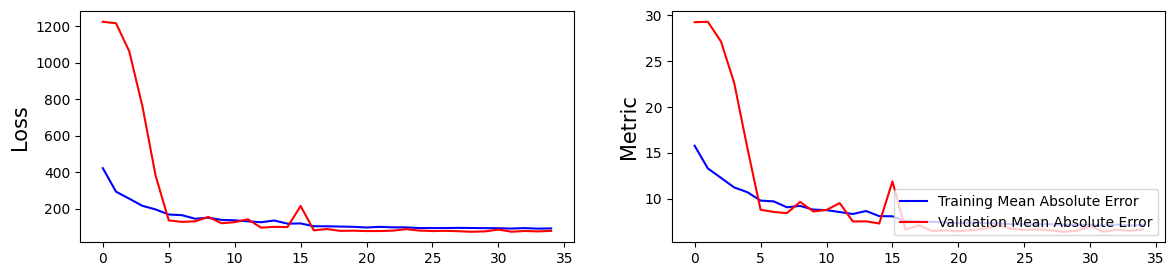

In [ ]:
age_model.plot_history(age_history)

In [ ]:
age_model.evaluate_model()

112/112 [==============================] - 1s 8ms/step - loss: 73.9979 - mae: 6.3632


(82.96857452392578, 6.64069128036499, 73.99794006347656, 6.363226890563965)

# Gender Model

In [ ]:
gender_model = GenderAgeEthnicityModel('gender', X, df['gender'], '/content/drive/MyDrive/DeepLearningProject/Gender&Age/', 'gender')

gender_callbacks = [EarlyStopping(monitor='val_loss',
                                  min_delta=0, patience=6,
                                  verbose=1,
                                  restore_best_weights=True),

                    gender_model.save_model_checkpoint(),

                    ReduceLROnPlateau(monitor='val_loss',
                                      factor=0.2,
                                      patience=3,
                                      verbose=1,
                                      min_delta=0.0001)]

In [ ]:
gender_history = gender_model.train_model(60, gender_callbacks)

Epoch 1/60
112/112 [==============================] - ETA: 0s - loss: 7.6951 - accuracy: 0.6610
Epoch 1: val_loss improved from inf to 7.64243, saving model to /content/drive/MyDrive/DeepLearningProject/Gender&Age/checkPoint_model_gender.h5
112/112 [==============================] - 15s 85ms/step - loss: 7.6951 - accuracy: 0.6610 - val_loss: 7.6424 - val_accuracy: 0.5163 - lr: 0.0100
Epoch 2/60
111/112 [============================>.] - ETA: 0s - loss: 7.2772 - accuracy: 0.7328
Epoch 2: val_loss improved from 7.64243 to 7.41618, saving model to /content/drive/MyDrive/DeepLearningProject/Gender&Age/checkPoint_model_gender.h5
112/112 [==============================] - 6s 54ms/step - loss: 7.2754 - accuracy: 0.7334 - val_loss: 7.4162 - val_accuracy: 0.5163 - lr: 0.0100
Epoch 3/60
112/112 [==============================] - ETA: 0s - loss: 6.9227 - accuracy: 0.7665
Epoch 3: val_loss improved from 7.41618 to 7.12965, saving model to /content/drive/MyDrive/DeepLearningProject/Gender&Age/check

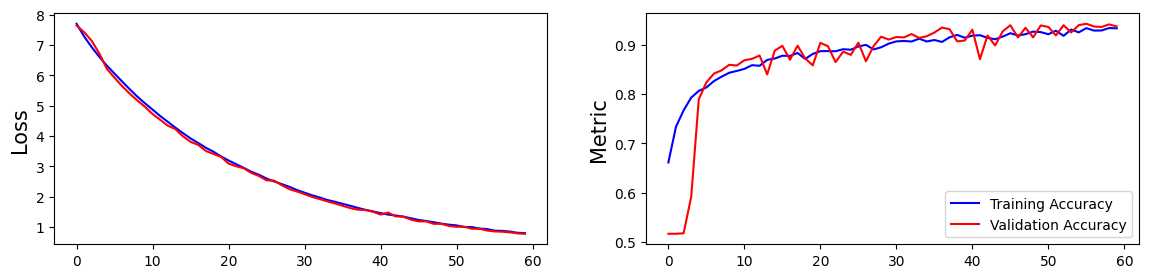

In [ ]:
gender_model.plot_history(gender_history)

In [ ]:
gender_model.evaluate_model()

112/112 [==============================] - 1s 12ms/step - loss: 0.7741 - accuracy: 0.9367


(0.7871483564376831,
 0.9330708384513855,
 0.7740764021873474,
 0.9367266297340393)

# Ethnicity Model

In [ ]:
ethnicity_model = GenderAgeEthnicityModel('ethnicity', X, df['ethnicity'], '/content/drive/MyDrive/DeepLearningProject/Gender&Age/', 'ethnicity')

ethnicity_callbacks = [EarlyStopping(monitor='val_loss',
                                     min_delta=0,
                                     patience=6,
                                     verbose=1,
                                     restore_best_weights=True),

                       ethnicity_model.save_model_checkpoint(),

                       ReduceLROnPlateau(monitor='val_loss',
                                         factor=0.2,
                                         patience=3,
                                         verbose=1,
                                         min_delta=0.0001)]

In [ ]:
ethnicity_history = ethnicity_model.train_model(60, ethnicity_callbacks)

Epoch 1/60
111/112 [============================>.] - ETA: 0s - loss: 5.4575 - accuracy: 0.3922
Epoch 1: val_loss improved from inf to 4.26565, saving model to /content/drive/MyDrive/DeepLearningProject/Gender&Age/checkPoint_model_ethnicity.h5
112/112 [==============================] - 12s 76ms/step - loss: 5.4286 - accuracy: 0.3919 - val_loss: 4.2656 - val_accuracy: 0.4258 - lr: 0.0010
Epoch 2/60
112/112 [==============================] - ETA: 0s - loss: 1.7594 - accuracy: 0.4872
Epoch 2: val_loss improved from 4.26565 to 3.07323, saving model to /content/drive/MyDrive/DeepLearningProject/Gender&Age/checkPoint_model_ethnicity.h5
112/112 [==============================] - 6s 55ms/step - loss: 1.7594 - accuracy: 0.4872 - val_loss: 3.0732 - val_accuracy: 0.4258 - lr: 0.0010
Epoch 3/60
112/112 [==============================] - ETA: 0s - loss: 1.5392 - accuracy: 0.5741
Epoch 3: val_loss improved from 3.07323 to 2.16943, saving model to /content/drive/MyDrive/DeepLearningProject/Gender&Age

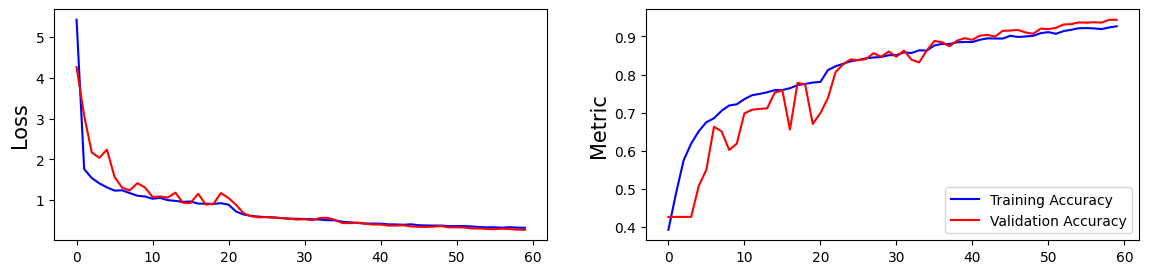

In [ ]:
ethnicity_model.plot_history(ethnicity_history)

In [ ]:
ethnicity_model.evaluate_model()

112/112 [==============================] - 1s 10ms/step - loss: 0.2680 - accuracy: 0.9439


(0.2891092300415039,
 0.9363048076629639,
 0.2680037319660187,
 0.9438976645469666)